Bring in the RLBench BC data from the saved hdf5 data files for each task. The task files were created with the instructRL/data/collect_data.py script. The task files include an array of data samples.  Each sample is a dict that includes the following keys:

* image - data for 4 camera positions: front_rgb, left_shoulder_rgb, right_shoulder_rgb, wrist_rgb
* instruct - the text instruction
* action - the action vector: [p;q;g] where for RLBench the gripper state is a single scalar open or closed [1,0]

In [1]:
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from getdata import RLBenchDataset
import torch
import time
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        # even indices are sine, odd indices are cosine
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[ batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [3]:


class ActionDecoderModel(nn.Module):

    def __init__(self, action_dim: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5, action_seq_len: int = 5,
                 mem_seq_len: int = 5, test_mode=False):
        super().__init__()
        self.pos_encoder = PositionalEncoding(d_model, dropout=0, max_len=action_seq_len).cuda()
        decoder_layer = TransformerDecoderLayer(d_model, nhead, d_hid, dropout, batch_first=True).cuda()
        self.transformer_decoder = TransformerDecoder(decoder_layer, nlayers).cuda()
        self.d_model = d_model
        self.linear_action_in = nn.Linear(action_dim, d_model).cuda()
        # The output of the transformer decoder is a sequence of length action_seq_len-1 because it doesn't have sos token
        self.linear_action_out = nn.Linear(d_model, action_dim).cuda()
        self.test_mode = test_mode
        

    def forward(self, actions: Tensor, memory: Tensor) -> Tensor:
        """
        actions: [batch_size, action_seq_len, action_dim]
        memory: [batch_size, mem_seq_len, d_model]
        """
        actions = self.linear_action_in(actions)
        actions = self.pos_encoder(actions)

        if self.test_mode:
            # If mixing tasks, then we will need padding masks in the batch
            output = self.transformer_decoder(
                tgt=actions, 
                memory=memory
                )
            
        else:
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(actions.size(1)).cuda()
            # causal memory mask to prevent attending to future actions of size mem_seq_len x action_seq_len upper triangular part should be True (is masked)
            mem_mask = torch.triu(torch.ones(actions.size(1), memory.size(1)), diagonal=1).bool().cuda()
            
            # If mixing tasks, then we will need padding masks in the batch
            output = self.transformer_decoder(
                tgt=actions, 
                memory=memory, 
                tgt_mask=tgt_mask,
                memory_mask=mem_mask
                )


        output = self.linear_action_out(output)
        return output

In [4]:



# Read in the RLBench training data.  The RLBenchDataset class is a subclass of the PyTorch Dataset class.
batch_size = 50
task_name = "reach_target"
# Load the training dataset and create a PyTorch DataLoader object.
train_dataset = RLBenchDataset(
    update=None,
    dataset_name=task_name,
    start_offset_ratio=None,
    split="train",
)

train_loader = torch.utils.data.DataLoader(    
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2)

# Load the validation dataset and create a PyTorch DataLoader object.
val_dataset = RLBenchDataset(
    update=None,
    dataset_name=task_name,
    start_offset_ratio=None,
    split="val",
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2)

In [5]:
print(f"Training dataset batch info:")
for i, (data, target) in enumerate(train_loader):
    print("action:", data['action'].shape)
    print("encoder_emb:", data['encoder_emb'].shape)
    print("target:", target.shape)
    break
print("num batches: " + str(len(train_loader)))

print(f"Val dataset batch info:")
for i, (data, target) in enumerate(val_loader):
    print("action:", data['action'].shape)
    print("encoder_emb:", data['encoder_emb'].shape)
    print("target:", target.shape)
    break
print("num batches: " + str(len(val_loader)))
print(data['action'].shape[1])


Training dataset batch info:
action: torch.Size([50, 3, 8])
encoder_emb: torch.Size([50, 2, 768])
target: torch.Size([50, 2, 8])
num batches: 23
Val dataset batch info:
action: torch.Size([50, 3, 8])
encoder_emb: torch.Size([50, 2, 768])
target: torch.Size([50, 2, 8])
num batches: 9
3


In [6]:

# max number of tokens in encoder embeddings for the training tasks in a batch. Can be constant if all same task, otherwise needs to be computed. Also determines whether a padding mask must be applied.  Determines the size of the causal mask and max
# max sequence length of the decoder action sequence and target output sequence. Decoder input size is seq_len + 2 to account for the start of sequence (sos) and end of sequence (eos) tokens.
action_seq_len = data['action'].shape[1]  # sos + action + eos, will need batch padding when mixing tasks
obs_seq_len = data['encoder_emb'].shape[1] 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
action_dim = 8 # feature length of the action vector [p;q;g]
mm_dim = 768  # embedding dimension of the encoder (768,)
d_hid = 768  # dimension of the feedforward network model in ``nn.TransformerDecoder``
nlayers = 6  # number of nn.TransformerDecoderLayer in nn.TransformerDecoder
nhead = 6  # number of attention heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
model = ActionDecoderModel(
    action_dim=action_dim, 
    d_model = mm_dim, 
    nhead = nhead, 
    d_hid = d_hid, 
    nlayers = nlayers, 
    dropout = dropout, 
    action_seq_len = action_seq_len,
    mem_seq_len = obs_seq_len,
    ).cuda()

In [7]:
# print whether model is on GPU or CPU
print(f"Model is on {next(model.parameters()).device}")

# Display the model architecture and number of trainable parameters
#print(model)

Model is on cuda:0


In [30]:


loss_fn = nn.MSELoss(
    reduction='mean'
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001,
    betas=(0.9, 0.999),
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, 
    gamma=0.7,
    verbose=False
)

epochs = 50 # The number of epochs

# Create a 2D array of zeros to store the training loss for each epoch x batch.
train_loss_buf = np.zeros((epochs, len(train_loader)))
def train(model: nn.Module) -> None:
    model.train()
    log_interval_loss = 0.
    start_time = time.time()

    for i, (batch, targets) in enumerate(train_loader):
        
        encoder_embeddings = batch['encoder_emb'].cuda()
        action_inputs = batch['action'].cuda()
        optimizer.zero_grad()
        outputs = model(actions=action_inputs, memory=encoder_embeddings)
        targets = torch.squeeze(targets).cuda()
        # Compare target sequence to output sequence, ignoring the output token after the eos token
        batch_train_loss = loss_fn(outputs[:,:-1,:], targets)
        batch_train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        log_interval_loss += batch_train_loss.item()
        train_loss_buf[epoch, i] = batch_train_loss.item()
        log_interval = 10
        if i % log_interval == 0 and i > 0:
            cur_loss = log_interval_loss / log_interval
            elapsed = time.time() - start_time
            # print(f'| epoch: {epoch:3d} | {i+1:5d}/{len(train_loader):5d} batches | '
            #       f'lr: {scheduler.get_last_lr()[0]:02.3f} | ms/batch: {elapsed * 1000 / log_interval:5.2f} | '
            #       f'log batch loss: {log_interval_loss:1.5f} | ')
            log_interval_loss = 0
            start_time = time.time()
        
        

In [31]:


val_loss_buf = np.zeros((epochs, len(val_loader)))
def evaluate(model: nn.Module, val_loader: iter) -> float:
    model.eval()  # turn on evaluation mode    
    with torch.no_grad():
        for i, (batch, targets) in enumerate(val_loader):
            encoder_embeddings = batch['encoder_emb'].cuda()
            action_inputs = batch['action'].cuda()
            targets = torch.squeeze(targets).cuda()
            outputs = model(actions=action_inputs, memory=encoder_embeddings)
            batch_val_loss = loss_fn(outputs[:,:-1,:], targets)
            val_loss_buf[epoch, i] = batch_val_loss.item()
            

In [32]:



for epoch in range(epochs):
        epoch_start_time = time.time()
        train(model)
        evaluate(model, val_loader)
        scheduler.step()
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'end of epoch: {epoch:3d} | epoc time: {elapsed:5.2f}s ')
        # print the total training and validation loss for the epoch
        print(f'train loss: {train_loss_buf[epoch,:].mean():5.4f}')              
        print(f'valid loss: {val_loss_buf[epoch,:].mean():5.4f}')
        print('-' * 89)
        
        

-----------------------------------------------------------------------------------------
end of epoch:   0 | epoc time:  3.14s 
train loss: 0.0149
valid loss: 0.0087
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
end of epoch:   1 | epoc time:  3.23s 
train loss: 0.0137
valid loss: 0.0081
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
end of epoch:   2 | epoc time:  3.14s 
train loss: 0.0128
valid loss: 0.0074
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
end of epoch:   3 | epoc time:  3.23s 
train loss: 0.0125
valid loss: 0.0090
--------------------------------------------------------------

In [ ]:
SAVE_MODEL = False

# Model path with date suffix
datestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
MODEL_PATH = f"/home/levi/data/action_decoder_model_{datestr}.pt"
if SAVE_MODEL:
    torch.save(model, MODEL_PATH)

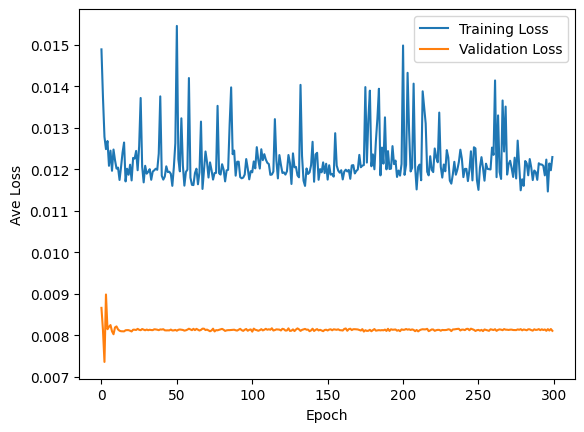

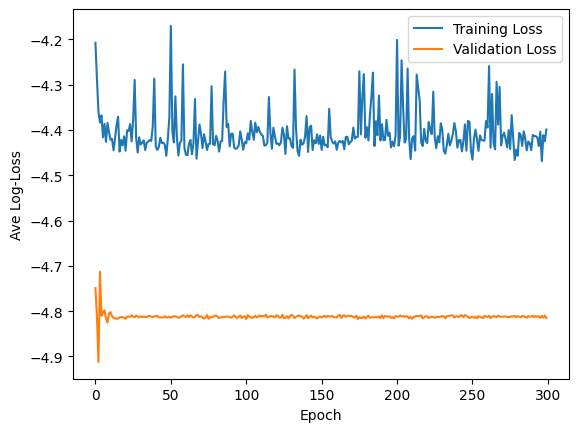

In [33]:
# plot the training loss for each epoch

plt.plot(np.vstack((np.mean(train_loss_buf, axis=1), np.mean(val_loss_buf, axis=1))).T)
# set the x axis tick labels to be the epoch numbers
plt.xlabel('Epoch')
plt.ylabel('Ave Loss')

# add a legend
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


plt.clf()
plt.plot(np.log(np.vstack((np.mean(train_loss_buf, axis=1), np.mean(val_loss_buf, axis=1))).T))
plt.xlabel('Epoch')
plt.ylabel('Ave Log-Loss')

# add a legend
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


In [14]:
# Now lets connect the current model to RLBench to step through the task and evaluate how often it receives a reward in the task.
from rlbench.action_modes.action_mode import MoveArmThenGripper
from rlbench.action_modes.arm_action_modes import EndEffectorPoseViaPlanning
from rlbench.action_modes.gripper_action_modes import Discrete
from rlbench.environment import Environment
from rlbench.observation_config import ObservationConfig
from rlbench.tasks import FS10_V1, ReachTarget, PickUpCup

In [15]:
from transformers import FlavaProcessor, FlavaModel
import numpy as np
import torch

class SlowAgent(object):
    """
    Agent that uses task description and observation to infer FLAVA autoencoder embeddings and then 
    predict the next action with the provided decoder autoregressively.
    
    """

    def __init__(self, decoder_model):
        self.action_shape = (8,)        
        self.encoder_emb = np.empty((1,0,768),dtype=np.float32)
        
        # begin with the sos token
        sos = torch.from_numpy(np.zeros((1,1,self.action_shape[0]), dtype=np.float32)).cuda()
        sos[0,0,0::2] = -1 # even values are -1
        self.decoder_actions = sos
        # Retrieve the Flava model and processor
        self.flava_model = FlavaModel.from_pretrained('facebook/flava-full')
        self.flava_processor = FlavaProcessor.from_pretrained('facebook/flava-full')
        self.action_decoder_model = decoder_model


    def get_flava_embeddings(self, img, instruction):
        # Convert the observation and instruction into a batch of inputs for the Flava model
        inputs = self.flava_processor(img, instruction, return_tensors="pt", padding="max_length", max_length=197, return_codebook_pixels=False, return_image_mask=False)
        # Pass the inputs through the Flava model
        outputs = self.flava_model(**inputs)
        # Retrieve the multimodal embeddings from the Flava model outputs
        multimodal_embeddings = outputs.multimodal_embeddings.detach().numpy()
        return multimodal_embeddings
    
    def act(self, img, instruction):        
        # Here we are submitting on image and one instruction at a time in an autoregressive fashion
        encoder_emb = self.get_flava_embeddings(img, instruction).squeeze()
        # Apply mean pooling to the encoder embeddings to get a single embedding for the observation
        mean_pool_emb = np.mean(encoder_emb, axis=0, dtype=np.float32).reshape(1,1,-1)
        # Concatenate the mean pooled embedding to the encoder embeddings
        self.encoder_emb = np.concatenate((self.encoder_emb, mean_pool_emb), axis=1)

        self.action_decoder_model.eval()  # turn on evaluation mode    
        memory_emb = torch.from_numpy(self.encoder_emb).cuda()
        with torch.no_grad():
            # Get the decoder action from the action decoder model
            decoder_action = self.action_decoder_model(actions=self.decoder_actions, memory=memory_emb) 
            # Normalize the quaternion values
            decoder_action[0,0,3:7] = decoder_action[0,0,3:7] / torch.norm(decoder_action[0,0,3:7])           
            # Add the action to the decoder actions
            self.decoder_actions = torch.cat((self.decoder_actions, decoder_action), dim=1)
        return decoder_action.detach().cpu().numpy().squeeze()


/home/levi/code/flava-action-xformer/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
obs_config = ObservationConfig()
obs_config.set_all(True)

env = Environment(
    action_mode=MoveArmThenGripper(
        arm_action_mode=EndEffectorPoseViaPlanning(absolute_mode=True), gripper_action_mode=Discrete()),
    obs_config=ObservationConfig(),
    headless=False)
env.launch()

`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.
Some weights of the model checkpoint at facebook/flava-full were not used when initializing FlavaModel: ['mmm_image_head.transform.dense.bias', 'image_codebook.blocks.group_4.group.block_2.res_path.path.conv_2.bias', 'image_codebook.blocks.group_1.group.block_2.res_path.path.conv_3.weight', 'itm_head.pooler.dense.weight', 'image_codebook.blocks.group_3.group.block_1.res_path.path.conv_2.weight', 'image_codebook.blocks.group_4.group.block_1.res_path.path.conv_3.bias', 'image_codebook.blocks.group_2.group.block_1.res_path.path.conv_3.w

touch the red ball with the panda gripper


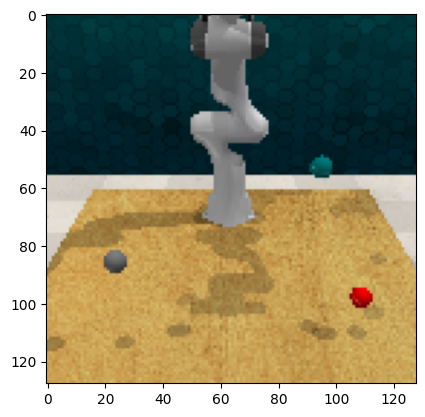

In [25]:
# Instantiate the agent
agent = SlowAgent(decoder_model=model)
# Get the task
task = env.get_task(ReachTarget)
# Reset the task
descriptions, obs = task.reset()
instruction = descriptions[1]
print(instruction)
plt.imshow(obs.front_rgb)
plt.show()


action: [ 0.29393977  0.10301365  1.0751342   0.00312696 -0.999862    0.01159936
  0.01146805  1.059511  ]
Step: 0 Reward: 0.0


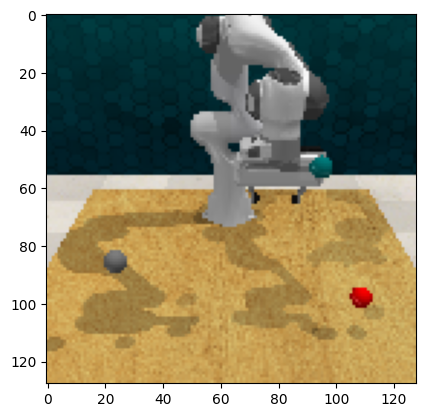

In [26]:
# Take steps in the task and print the reward
for i in range(1):
    action = agent.act(obs.front_rgb, instruction)
    print(f'action: {action}')
    if action[0] > 0:
        obs, reward, terminate = task.step(action)
        print(f'Step: {i} Reward: {reward}')
    else:
        print("No action taken")
        break
    plt.imshow(obs.front_rgb)

In [34]:
env.shutdown()

[CoppeliaSim:loadinfo]   done.
